# Max Pool MIL

Now we're going to load and train and MIL network on MNIST (presence of 0 = positive bag).

In [1]:
import numpy as np
import pandas as pd
import sklearn.model_selection
import tensorflow as tf
import tensorflow_addons as tfa
from noisy_and import NoisyAnd
from tensorflow.keras import layers
from utils import plot_results

np.random.seed(42)
tf.random.set_seed(42)

N_CLASSES = 2
MAX_BAG = 7

print(tf.__version__)

2.4.1


In [2]:
def preprocess_mil(dataset, prefix):
  (x_train, _), (x_test, _) = dataset

  # Standardize
  x_train = x_train[..., np.newaxis] / 255 #tf.image.per_image_standardization(x_train[..., np.newaxis]).numpy()
  x_test = x_test[..., np.newaxis] / 255 #tf.image.per_image_standardization(x_test[..., np.newaxis]).numpy()
  
  x_train, y_train = load_mil(x_train, prefix + '_train.csv')
  x_test, y_test = load_mil(x_test, prefix + '_test.csv')

  return (x_train, y_train), (x_test, y_test)

def load_mil(x_orig, csv):
  df = pd.read_csv(csv)
  
  x = np.zeros((df.shape[0], MAX_BAG) +  x_orig[0].shape)
  for i, r in df.iterrows():
    idx = r[1:][r[1:] != -1]
    x[i, :idx.shape[0]] = x_orig[idx]
  
  y = tf.one_hot(df.y, N_CLASSES).numpy()
  
  return x, y

def load_fashion():
  return preprocess_mil(tf.keras.datasets.fashion_mnist.load_data(), 'data/fashion')

def load_mnist():
  return preprocess_mil(tf.keras.datasets.mnist.load_data(), 'data/mnist')

def load_outfit():
  return preprocess_mil(tf.keras.datasets.fashion_mnist.load_data(), 'data/outfit')

In [3]:
def evaluate(create_model, load_dataset, epochs=10, batch_size=64):
  (x_train, y_train), (x_test, y_test) = load_dataset()
  
  print('----- Data -----')
  print(f'Train : x={x_train.shape}, y={y_train.shape}')
  print(f'Test  : x={x_test.shape}, y={y_test.shape}')
  print(f'Splits: train={y_train.sum(axis=0).astype(int)}, test={y_test.sum(axis=0).astype(int)}')
  print('----------------') 

  model = create_model()

  return model.fit(
      x_train, y_train,
      callbacks=[ tf.keras.callbacks.EarlyStopping(
          monitor='val_loss',
          patience=5,
          restore_best_weights=True
      ) ],
      validation_data=(x_test, y_test),
      epochs=epochs,
      batch_size=batch_size,
  )

In [4]:
def define_model():
  model = tf.keras.Sequential([
      layers.Input((MAX_BAG, 28, 28, 1)),
      layers.TimeDistributed(layers.Conv2D(64, 2, activation='relu', padding='same')),
      layers.TimeDistributed(layers.MaxPool2D(2)),
      layers.TimeDistributed(layers.Conv2D(32, 3, activation='relu')),
      layers.TimeDistributed(layers.MaxPool2D(2)),
      layers.TimeDistributed(layers.Dropout(0.3)),
      layers.TimeDistributed(layers.Flatten()),
      layers.TimeDistributed(layers.Dense(256, activation='relu')),
      layers.TimeDistributed(layers.Dropout(0.5)),
      layers.TimeDistributed(layers.Dense(N_CLASSES, activation='softmax')),
      layers.Flatten(),
      layers.Dense(N_CLASSES, activation='softmax'),
  ])

  model.compile(
      optimizer=tf.optimizers.Adam(),
      loss=tf.losses.CategoricalCrossentropy(),
      metrics=[
          tf.metrics.Precision(name='prec'),
          tf.metrics.Recall(name='rec'),
          tf.metrics.AUC(name='auc'),
          tfa.metrics.F1Score(N_CLASSES, name='f1'),
      ],
  )
  return model

print(define_model().summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 7, 28, 28, 64)     320       
_________________________________________________________________
time_distributed_1 (TimeDist (None, 7, 14, 14, 64)     0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, 7, 12, 12, 32)     18464     
_________________________________________________________________
time_distributed_3 (TimeDist (None, 7, 6, 6, 32)       0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, 7, 6, 6, 32)       0         
_________________________________________________________________
time_distributed_5 (TimeDist (None, 7, 1152)           0         
_________________________________________________________________
time_distributed_6 (TimeDist (None, 7, 256)            2

----- Data -----
Train : x=(13294, 7, 28, 28, 1), y=(13294, 2)
Test  : x=(2233, 7, 28, 28, 1), y=(2233, 2)
Splits: train=[8365 4929], test=[1402  831]
----------------
Epoch 1/10
208/208 [==============================] - 51s 236ms/step - loss: 0.7964 - prec: 0.4638 - rec: 0.4638 - auc: 0.4495 - f1: 0.4155 - val_loss: 0.6601 - val_prec: 0.6279 - val_rec: 0.6279 - val_auc: 0.6279 - val_f1: 0.3857
Epoch 2/10
208/208 [==============================] - 50s 240ms/step - loss: 0.6571 - prec: 0.6337 - rec: 0.6337 - auc: 0.6287 - f1: 0.3879 - val_loss: 0.6602 - val_prec: 0.6279 - val_rec: 0.6279 - val_auc: 0.6279 - val_f1: 0.3857
Epoch 3/10
208/208 [==============================] - 49s 238ms/step - loss: 0.6596 - prec: 0.6291 - rec: 0.6291 - auc: 0.6257 - f1: 0.3862 - val_loss: 0.6601 - val_prec: 0.6279 - val_rec: 0.6279 - val_auc: 0.6279 - val_f1: 0.3857
Epoch 4/10
208/208 [==============================] - 48s 232ms/step - loss: 0.6571 - prec: 0.6337 - rec: 0.6337 - auc: 0.6313 - f1: 0.3879

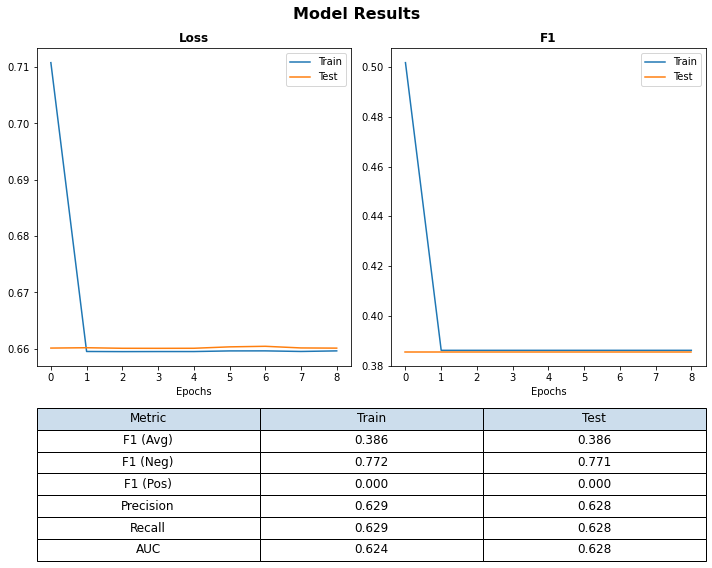

In [5]:
history = evaluate(define_model, load_mnist)
plot_results(history, filename='img/dense-mnist.jpg')

----- Data -----
Train : x=(13294, 7, 28, 28, 1), y=(13294, 2)
Test  : x=(2233, 7, 28, 28, 1), y=(2233, 2)
Splits: train=[8314 4980], test=[1400  833]
----------------
Epoch 1/10
208/208 [==============================] - 50s 233ms/step - loss: 0.7004 - prec: 0.5294 - rec: 0.5294 - auc: 0.5387 - f1: 0.4504 - val_loss: 0.6606 - val_prec: 0.6270 - val_rec: 0.6270 - val_auc: 0.6270 - val_f1: 0.3854
Epoch 2/10
208/208 [==============================] - 50s 239ms/step - loss: 0.6624 - prec: 0.6235 - rec: 0.6235 - auc: 0.6241 - f1: 0.3841 - val_loss: 0.6608 - val_prec: 0.6270 - val_rec: 0.6270 - val_auc: 0.6270 - val_f1: 0.3854
Epoch 3/10
208/208 [==============================] - 46s 223ms/step - loss: 0.6588 - prec: 0.6307 - rec: 0.6307 - auc: 0.6296 - f1: 0.3868 - val_loss: 0.6607 - val_prec: 0.6270 - val_rec: 0.6270 - val_auc: 0.6270 - val_f1: 0.3854
Epoch 4/10
208/208 [==============================] - 45s 216ms/step - loss: 0.6601 - prec: 0.6282 - rec: 0.6282 - auc: 0.6276 - f1: 0.3858

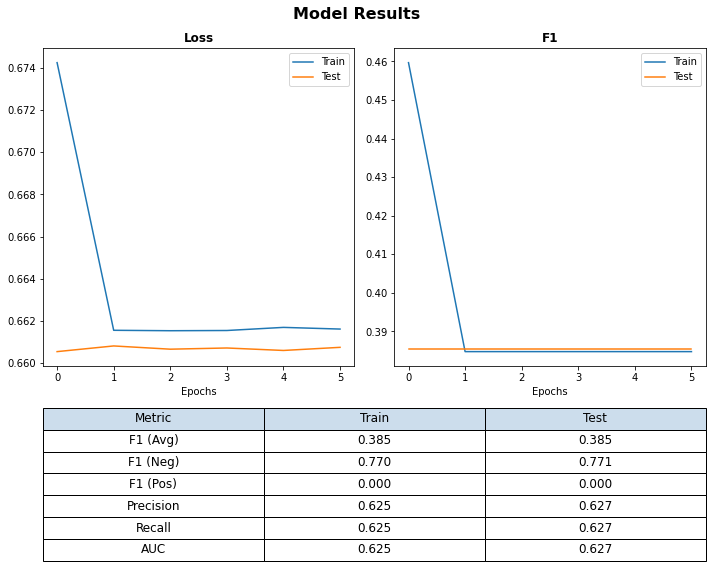

In [6]:
history = evaluate(define_model, load_fashion)
plot_results(history, filename='img/dense-fashion.jpg')

----- Data -----
Train : x=(13294, 7, 28, 28, 1), y=(13294, 2)
Test  : x=(2233, 7, 28, 28, 1), y=(2233, 2)
Splits: train=[9987 3307], test=[1683  550]
----------------
Epoch 1/10
208/208 [==============================] - 47s 218ms/step - loss: 0.5721 - prec: 0.7481 - rec: 0.7481 - auc: 0.7732 - f1: 0.4584 - val_loss: 0.5167 - val_prec: 0.7591 - val_rec: 0.7591 - val_auc: 0.8286 - val_f1: 0.4574
Epoch 2/10
208/208 [==============================] - 46s 221ms/step - loss: 0.5080 - prec: 0.7587 - rec: 0.7587 - auc: 0.8377 - f1: 0.4956 - val_loss: 0.4710 - val_prec: 0.7649 - val_rec: 0.7649 - val_auc: 0.8708 - val_f1: 0.5009
Epoch 3/10
208/208 [==============================] - 46s 221ms/step - loss: 0.4611 - prec: 0.7699 - rec: 0.7699 - auc: 0.8763 - f1: 0.5486 - val_loss: 0.4305 - val_prec: 0.7806 - val_rec: 0.7806 - val_auc: 0.8982 - val_f1: 0.5655
Epoch 4/10
208/208 [==============================] - 46s 221ms/step - loss: 0.4188 - prec: 0.7911 - rec: 0.7911 - auc: 0.9041 - f1: 0.6119

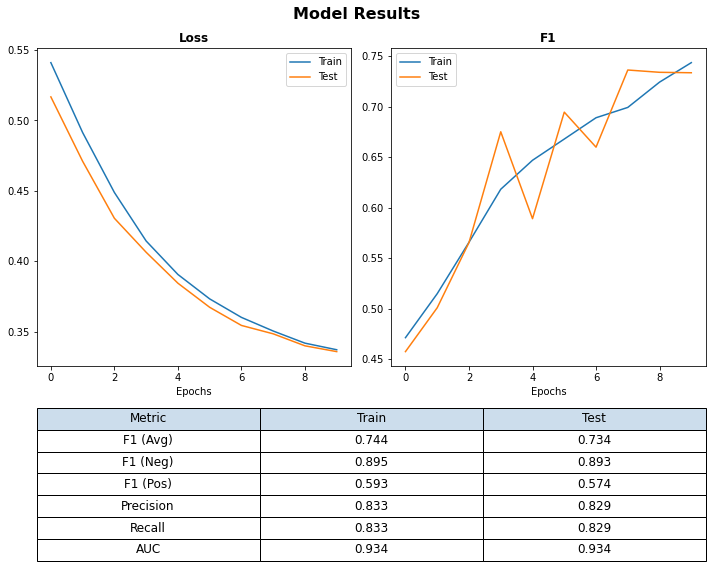

In [7]:
history = evaluate(define_model, load_outfit)
plot_results(history, filename='img/dense-outfit.jpg')